# Chapter 16: Reinforcement Learning

## Exercises

### 1. How would you describe Reinforcement Learning? How is it different from regular supervised or unsupervised learning?

Reinforcement learning is the process of training a computer agent to complete make actions in an environment in order to earn rewards. The goal of RL is to train an agent policy which maximizes the reward the agent can accumulate. This differs from regular machine learning tasks which do not train an agent to take actions in an environment. 

### 2. Can you think of three possible applications of RL that were not mentioned in this chapter? For each of them, what is the environment? What is the agent? What are the possible actions? What are the rewards?

One application could be self-flying drones that are used to make deliveries. The environment is the physical world; the agent is the drone; the possible actions would be the different directions the drone could fly; and the rewards could be a function of the distance between the drone and the destination, if the drone was successfully able to reach the destination without hitting an obstacle, or the time it takes the drone to reach its destination.

Another application is training a model to learn to play a card game with fixed rules such as Blackjack. The environment would be a simulation of the card game. The agent would be a bot that plays the game. The possible actions would be two actions one can take while playing. The reward could be if the agent wins or loses the hand. You could also incorporate a betting round at the beginning of each hand and the goal could be trying to make as much money as possible.

A third application could be a cryptocurrency trading. The environment could be realtime prices of various cryptocurrencies. The agent could be a trading bot with access to cryptocurrency wallets for the different currencies. The The possible actions could be whether to buy or sell a particular amount of a certain cryptocurrency. The reward could be how much the agent's portfolio is worth in USD.



### 3. What is the discount rate? Can the optimal policy change if you modify the discount rate?

The discount rate is a constant (usually 0.95 or 0.99) that we multiply the rewards an agent gets from future actions. We do this so that the model slightly prefers short term rewards to rewards in the future. A different discount rate can cause a model to value long term reward more or less, which could change the policy the model learns.

### 4. How do you measure the performance of a Reinforcement Learning agent?

You measure the performance of an RL agent by either measuring how much reward the agent is able to accumulate while it performs the task. A more subjective way of measuring the performance is to observe the agent acting in its environment and see if you are satisfied with its performance.

### 5. What is the credit assignment problem? What does it occur? How can you alleviate it?

The credit assignment problem is the problem where an agent cannot determine what the long term effects of its immediate actions may be, so it cannot decide which next action will yield the most reward. You can alleviate the problem by training an agent using a Policy Gradients algorithm so it can learn what actions lead to later rewards.

### 6. What is the point of using a replay memory?

A replay memory stores an agent's past experience, e.g. an action it took, the state when it took the action, and what the resulting state was. During training, a model will randomly sample batches of memories from the replay memory, rather than only using its most recent experiences. The purpose of doing this is so that the agent does not correlate its policy too strongly to its most recent experiences.

### 7. What is an off-policy RL algorithm?

An off-policy RL algorithm is an algorithm that is different when it is being trained than whan it is executing the task it is being trained for. An example of an off-policy algorithm is the DQN trained to play Ms. PacMan in `MsPacMan.ipynb`.

### 8. Use policy gradients to tackle OpenAI gym's "BipedalWalker-v2"

Setting up...

In [0]:
import tensorflow as tf
import numpy as np
import os
import sys

def reset_graph(seed=42):
  tf.reset_default_graph()
  tf.set_random_seed(seed)
  np.random.seed(seed)

%matplotlib inline
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

Let's explore the BipedalWalker-v2 environment.

In [0]:
# I need to install these modules to get the environment working in Colab.

!pip install box2d-py
!pip install gym[Box_2D]
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install pyglet==1.3.2

In [0]:
import gym

env = gym.make('BipedalWalker-v2')
obs = env.reset()

In [0]:
obs.shape

(24,)

In [0]:
from pyvirtualdisplay import Display

display = Display(visible=0, size=(400, 300))
display.start()

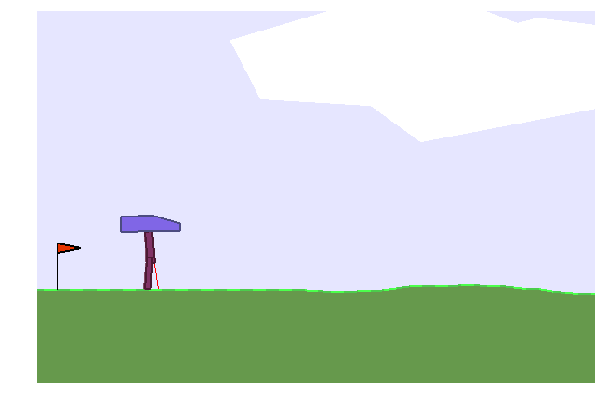

In [0]:
# Rendering the Bipedal Walker environment.

img = env.render(mode='rgb_array')
plt.figure(figsize=(10,8))
plt.imshow(img)
plt.axis('off')
plt.show()

In [0]:
env.action_space

Box(4,)

According to OpenAI Gym's documentation, the action space in this case is an array of 4 continuous values from -1 to 1. They represent the torques the agent can apply on its joints.

Let's run the environment with random actions and see what the environment looks like when the episode finishes. After running the code below, we see that the episode ends when the walker falls.

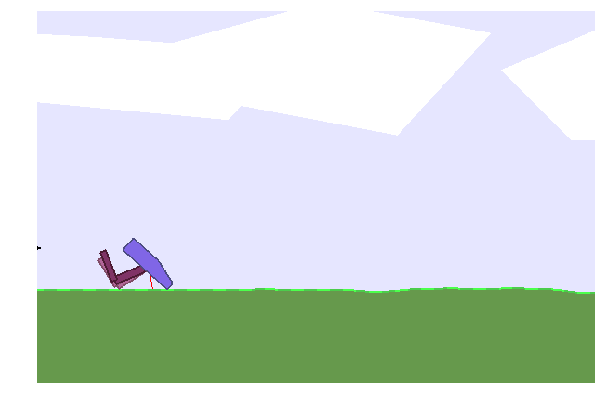

In [0]:
obs = env.reset()

for _ in range(100):
  obs, reward, done, info = env.step(env.action_space.sample())
  if done:
    break

img = env.render(mode='rgb_array')
plt.figure(figsize=(10,8))
plt.imshow(img)
plt.axis('off')
plt.show()

Before training the neural network using policy gradients, let's plot the animation of a random policy.

In [0]:
# Setting up to plot animations.

from IPython.display import HTML

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
  plt.close()
  fig = plt.figure()
  patch = plt.imshow(frames[0])
  plt.axis('off')
  anim = animation.FuncAnimation(fig, update_scene, fargs=(frames, patch),
                                 frames=len(frames), repeat=repeat,
                                 interval=interval)
  return HTML(anim.to_html5_video())

In [0]:
# Running an episode with a randomized policy.

frames = []
n_max_steps = 1000

obs = env.reset()
for _ in range(n_max_steps):
  obs, reward, done, info = env.step(env.action_space.sample())
  frames.append(env.render(mode='rgb_array'))
  if done:
    break

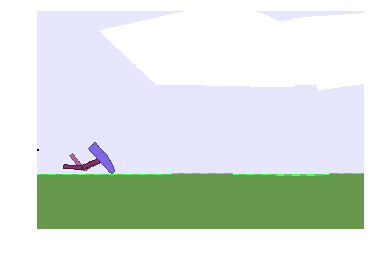

In [0]:
plot_animation(frames)

Now let's start training a neural network using policy gradients. Unlike the example in `ReinforcementLearning.ipynb` which had a discrete action space, this environment has a continuous action space. In order to deal with the continuous action space, let's discretize it.

In [0]:
from itertools import product

possible_torques = np.array([-1.0, 0.0, 1.0])
possible_actions = np.array(list(product(*(4 * (possible_torques,)))))

In [0]:
# There are 84 possible actions, one for each combination of -1, 0, and 1 for
# all 4 values for each action.

possible_actions.shape

(81, 4)

In [0]:
from functools import partial

reset_graph()
obs = env.reset()

n_inputs = obs.shape[0]
n_hidden = 100
n_actions = len(possible_actions)

learning_rate = 1e-2

he_init = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=(None, n_inputs))

dense = partial(tf.layers.dense, kernel_initializer=he_init,
                activation=tf.nn.relu)

hidden = dense(X, n_hidden)
logits = dense(hidden, n_actions, activation=None)
outputs = tf.nn.softmax(logits)

action_idx = tf.squeeze(tf.multinomial(tf.log(outputs), num_samples=1),
                        axis=-1)
# The target probabilities is 1 for the index of the chosen action.
y = tf.one_hot(action_idx, depth=n_actions)

xentropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=logits)
optimizer = tf.train.AdamOptimizer(learning_rate)

grads_and_vars = optimizer.compute_gradients(xentropy)
gradients = [grad for grad, variable in grads_and_vars]
gradient_placeholders = []
grads_and_vars_feed = []
for grad, variable in grads_and_vars:
  gradient_placeholder = tf.placeholder(tf.float32, shape=grad.get_shape())
  gradient_placeholders.append(gradient_placeholder)
  grads_and_vars_feed.append((gradient_placeholder, variable))
  
training_op = optimizer.apply_gradients(grads_and_vars_feed)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [0]:
# Defining functions for getting the discounted rewards.

def get_discount_rewards(rewards, discount_rate):
  """Compute the cumulative rewards of actions based on their current reward
  and the reward that future actions will bring.

  We multiply future actions by a "discount rate" so that the more short term
  rewards are more valuable than eventual long term rewards.
  
  """
  cumulative_rewards = [None] * len(rewards)
  cumulative_reward = 0.0
  for idx, reward in reversed(list(enumerate(rewards))):
    cumulative_reward = reward + (discount_rate * cumulative_reward)
    cumulative_rewards[idx] = cumulative_reward
  return cumulative_rewards

def discount_and_normalize_rewards(all_rewards, discount_rate):
  all_discounted_rewards = \
      [get_discount_rewards(rewards, discount_rate) for rewards in all_rewards]
  flat_rewards = np.concatenate(all_discounted_rewards)
  reward_mean = np.mean(flat_rewards)
  reward_stddev = np.std(flat_rewards)
  return [(rewards - reward_mean) / reward_stddev
          for rewards in all_discounted_rewards]

In [0]:
# Mounting Google Drive to store the model checkpoint data even if we lose
# the kernel.

from google.colab import drive

drive.mount('/content/gdrive/')
checkpoint_path = '/content/gdrive/My Drive/models/bipedal_walker.ckpt'

In [0]:
# Train the model to teach the agent to walk.

n_games_per_update = 25
n_max_steps = 1000
n_iterations = 1000
save_iterations = 10
discount_rate = 0.99

with tf.Session() as sess:
  init.run()
  for iteration in range(n_iterations):
    print('\rIteration {}'.format(iteration), end='')
    all_rewards = []
    all_gradients = []
    for game in range(n_games_per_update):
      current_rewards = []
      current_gradients = []
      obs = env.reset()
      for step in range(n_max_steps):
        action_val, gradients_val = sess.run([action_idx, gradients],
                                             feed_dict={
                                                 X: obs.reshape(1, n_inputs),
                                             })
        obs, reward, done, info = env.step(possible_actions[action_val[0]])
        current_rewards.append(reward)
        current_gradients.append(gradients_val)
        if done:
          break
      all_rewards.append(current_rewards)
      all_gradients.append(current_gradients)
      
    all_rewards = discount_and_normalize_rewards(all_rewards, discount_rate)
    feed_dict = dict()
    for var_idx, gradient_placeholder in enumerate(gradient_placeholders):
      mean_gradients = np.mean([reward * all_gradients[game_idx][step][var_idx]
                                for game_idx, rewards in enumerate(all_rewards)
                                for step, reward in enumerate(rewards)],
                               axis=0)
      feed_dict[gradient_placeholder] = mean_gradients
    sess.run(training_op, feed_dict=feed_dict)
    if iteration % save_iterations == 0:
      saver.save(sess, checkpoint_path)
  saver.save(sess, checkpoint_path)

In [0]:
# Playing the game with the trained model to see how it does.

n_max_steps = 1000
frames = []

with tf.Session() as sess:
  saver.restore(sess, checkpoint_path)
  obs = env.reset()
  for _ in range(n_max_steps):
    action_idx_val = sess.run(action_idx,
                              feed_dict={X: obs.reshape(1, n_inputs)})
    action = possible_actions[action_idx_val[0]]
    obs, reward, done, info = env.step(action)
    frames.append(env.render(mode='rgb_array'))
    if done:
      break

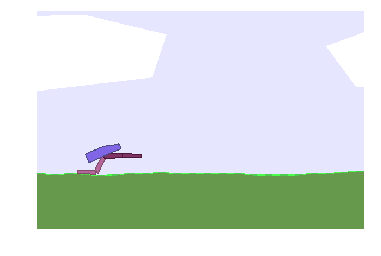

In [0]:
# Plot the animation. As we can see the model learned to stay upright by using
# the back leg as support and then inches forward using the front leg. Not
# quite what we expected but it is able to last 1000 frames without falling.

plot_animation(frames)

### 9. Use the DQN algorithm to train an agent to play _Pong_, the famous Atari game.

Setting up...

In [0]:
import tensorflow as tf
import numpy as np
import os
import sys

def reset_graph(seed=42):
  tf.reset_default_graph()
  tf.set_random_seed(seed)
  np.random.seed(seed)

%matplotlib inline
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

Let's explore the `Pong-v0` OpenAI Gym environment.

In [0]:
import gym

env = gym.make('Pong-v0')
obs = env.reset()

In [0]:
obs.shape

(210, 160, 3)

In [0]:
env.action_space

Discrete(6)

We see the observation space is a 210x160 RGB image. The action space is a `Discrete(6)` space with 6 different actions: actions 0 and 1 do nothing, actions 2 and 4 move the paddle up, and finally actions 3 and 5 move the paddle down. The paddle is free to move immediately but the ball does not appear until after 18 steps into the episode.

Let's play a game with a completely random policy and plot the resulting animation.

In [0]:
# Setting up to plot animations.

from IPython.display import HTML

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
  plt.close()
  fig = plt.figure()
  patch = plt.imshow(frames[0])
  plt.axis('off')
  anim = animation.FuncAnimation(fig, update_scene, fargs=(frames, patch),
                                 frames=len(frames), repeat=repeat,
                                 interval=interval)
  return HTML(anim.to_html5_video()) 

In [0]:
# A helper function to run an episode of Pong. It's first argument should be a
# function which takes the observation of the environment and the current
# iteration and produces an action for the agent to take.

def run_episode(policy, n_max_steps=1000, frames_per_action=1):
  obs = env.reset()
  frames = []
  for i in range(n_max_steps):
    obs, reward, done, info = env.step(policy(obs, i))
    frames.append(env.render(mode='rgb_array'))
    if done:
      break
  return plot_animation(frames)

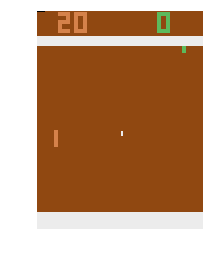

In [0]:
run_episode(lambda obs, i: np.random.randint(0, 5))

The random policy does not fare very well. So let's try to use the DQN and see if we can do better.

First let's write a preprocessing function to scale down the input state. Since a single observation does not tell us about the ball's velocity, we will also need to combine multiple observations into a single state. Below is the preprocessing code for this environment. The preprocessing algorithm is two-fold:

1. Convert the image in the observation to an image to only black and white and scale it down to 80x80 pixels.

2. Combine 3 observations into a single state which depicts the velocity of the paddles and the ball.

In [0]:
green_paddle_color = (92, 186, 92)
red_paddle_color = (213, 130, 74)
background_color = (144, 72, 17)
ball_color = (236, 236, 236)

def preprocess_observation(obs):
  img = obs[34:194:2, ::2].reshape(-1, 3)
  tmp = np.full(shape=(80 * 80), fill_value=0.0, dtype=np.float32)
  for i, c in enumerate(img):
    c = tuple(c)
    if c in {green_paddle_color, red_paddle_color, ball_color}:
      tmp[i] = 1.0
    else:
      tmp[i] = 0.0
  return tmp.reshape(80, 80)

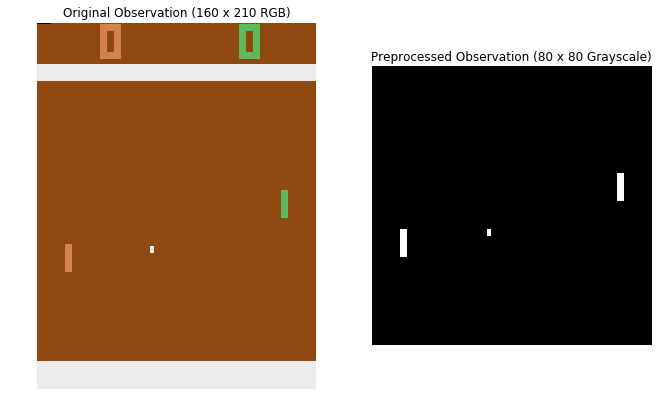

In [0]:
obs = env.reset()
for _ in range(25):
  obs, _, _, _ = env.step(0)

plt.figure(figsize=(11, 7))
plt.subplot(121)
plt.title('Original Observation (160 x 210 RGB)')
plt.imshow(obs)
plt.axis('off')
plt.subplot(122)
plt.title('Preprocessed Observation (80 x 80 Grayscale)')
plt.imshow(preprocess_observation(obs), interpolation='nearest', cmap='gray')
plt.axis('off')
plt.show()

In [0]:
def combine_observations(preprocess_observations, dim_factor=0.75):
  dimmed = [obs * (dim_factor ** idx)
            for idx, obs in enumerate(reversed(preprocess_observations))]
  return np.max(np.array(dimmed), axis=0)

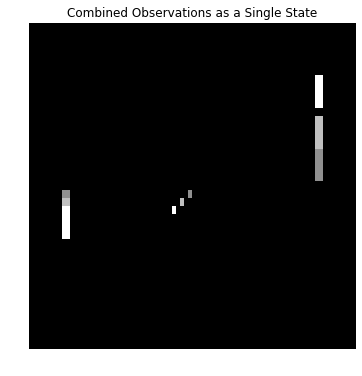

In [0]:
n_observations_per_state = 3

obs = env.reset()
for _ in range(20):
  obs, _, _, _ = env.step(0)
  
preprocess_observations = []
for _ in range(n_observations_per_state):
  obs, _, _, _ = env.step(2)
  preprocess_observations.append(preprocess_observation(obs))

img = combine_observations(preprocess_observations)

plt.figure(figsize=(6, 6))
plt.title('Combined Observations as a Single State')
plt.imshow(img, interpolation='nearest', cmap='gray')
plt.axis('off')
plt.show()

Now we are going to build the DQN. Like the DQN for Pac-Man, this model will train 3 convolutional layers, then a hidden fully connected layer, then finally a fully connected layer with 6 neurons, one representing each possible output.

In [0]:
reset_graph()

input_width = 80
input_height = 80
input_channels = 1

conv_n_maps = [32, 64, 64]
conv_kernel_sizes = [9, 5, 3]
conv_kernel_strides = [4, 2, 1]
conv_paddings = ['VALID'] * 3
conv_activation = [tf.nn.relu] * 3

n_hidden_in = 5 * 5 * 64
n_hidden = 512
hidden_activation = tf.nn.relu
n_outputs = env.action_space.n

he_init = tf.contrib.layers.variance_scaling_initializer()

This model will use two DQNs, an online DQN and a target DQN. The online DQN learns new parameters at each training step. The target DQN is used to compute the target Q-Values for the online DQN's loss function during training. The online DQN's parameters are copied to the target DQN at regular intervals.

In [0]:
def q_network(X_state, name):
  prev_layer = X_state
  with tf.variable_scope(name) as scope:
    for n_maps, kernel_size, strides, padding, activation in zip(
        conv_n_maps, conv_kernel_sizes, conv_kernel_strides, conv_paddings,
        conv_activation):
      prev_layer = tf.layers.conv2d(prev_layer, filters=n_maps,
                                    kernel_size=kernel_size, strides=strides,
                                    padding=padding, activation=activation,
                                    kernel_initializer=he_init)
    flattened = tf.reshape(prev_layer, [-1, n_hidden_in])
    hidden = tf.layers.dense(flattened, n_hidden, activation=hidden_activation,
                             kernel_initializer=he_init)
    outputs = tf.layers.dense(hidden, n_outputs, kernel_initializer=he_init)
  trainable_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                     scope=scope.name)
  trainable_vars_by_name = {var.name[len(scope.name):]: var
                            for var in trainable_vars}
  return outputs, trainable_vars_by_name

In [0]:
# Starting the DQN definition.

X_state = tf.placeholder(tf.float32, shape=(None, input_height, input_width,
                                            input_channels))
online_q_values, online_vars = q_network(X_state, 'q_networks/online')
target_q_values, target_vars = q_network(X_state, 'q_networks/target')
copy_ops = [var.assign(online_vars[name]) for name, var in target_vars.items()]
copy_online_to_target = tf.group(*copy_ops)

In [0]:
# Defining the training objective.

learning_rate = 1e-3
momentum = 0.95

with tf.variable_scope('training') as scope:
  X_action = tf.placeholder(tf.int32, shape=(None,))
  y = tf.placeholder(tf.float32, shape=(None, 1))
  Q_target = tf.reduce_sum(online_q_values * tf.one_hot(X_action, n_outputs),
                           axis=1, keepdims=True)
  error = tf.abs(y - Q_target)
  loss = tf.reduce_mean(tf.square(error))
  
  global_step = tf.Variable(0, trainable=False, name='global_step')
  optimizer = tf.train.MomentumOptimizer(learning_rate, momentum,
                                         use_nesterov=True)
  training_op = optimizer.minimize(loss, global_step=global_step)

In [0]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

This model will sample past experiences from a _Replay Memory_, this will hopefully help the model learn what higher level patterns to pay attention to to find the right action. It also reduces the chance that the model's behavior gets too correlated to it's most recent experiences.

The replay memory will store its data in the kernel's memory.

In [0]:
class ReplayMemory(object):
  def __init__(self, maxlen):
    self.maxlen = maxlen
    self.buf = np.empty(shape=maxlen, dtype=np.object)
    self.index = 0
    self.length = 0
    
  def append(self, data):
    self.buf[self.index] = data
    self.index += 1
    self.index %= self.maxlen
    self.length = min(self.length + 1, self.maxlen)
    
  def sample(self, batch_size):
    return self.buf[np.random.randint(self.length, size=batch_size)]

In [0]:
replay_size = 200000
replay_memory = ReplayMemory(replay_size)

In [0]:
def sample_memories(batch_size):
  cols = [[], [], [], [], []]  # state, action, reward, next_state, continue
  for memory in replay_memory.sample(batch_size):
    for col, value in zip(cols, memory):
      col.append(value)
  cols = [np.array(col) for col in cols]
  return cols[0], cols[1], cols[2].reshape(-1, 1), cols[3], \
      cols[4].reshape(-1, 1)

Now let's define the model's policy during training. Just like in `MsPacMan.ipynb`, we will use an $\varepsilon$-greedy policy.

In [0]:
eps_min = 0.1
eps_max = 1.0
eps_decay_steps = 6000000

def epsilon_greedy(q_values, step):
  epsilon = min(eps_min,
                eps_max - ((eps_max - eps_min) * (step / eps_decay_steps)))
  if np.random.random() < epsilon:
    return np.random.randint(n_outputs)
  return np.argmax(q_values)

Since I am running this notebook in Colab, I will use Google Drive to save the model parameters. This way if the kernel gets shut down after 12 hours, I will not lose my training progress.

In [0]:
from google.colab import drive

drive.mount('/content/gdrive/')

In [0]:
checkpoint_path = '/content/gdrive/My Drive/models/pong_dqn.ckpt'

Now we will train the model to play some Pong. The model will input an action once every 3 frames. The preprocessing functions defined above will use the 3 frames to compute the state the model will use to 

In [0]:
n_steps = 10000000
training_start = 100000
training_interval = 4
save_steps = 1000
copy_steps = 10000
discount_rate = 0.95
skip_start = 20
batch_size = 50
iteration = 0
done = True  # To reset the environment at the start.

loss_val = np.infty
game_length = 0
total_max_q = 0.0
mean_max_q = 0.0

In [0]:
# Utility function to get the environment state for the model.

def perform_action(action):
  preprocess_observations = []
  total_reward = 0.0
  for i in range(3):
    obs, reward, done, info = env.step(action)
    total_reward += reward
    if done:
      for _ in range(i, 3):
        preprocess_observations.append(preprocess_observation(obs))
      break
    else:
      preprocess_observations.append(preprocess_observation(obs))
  return combine_observations(preprocess_observations).reshape(80, 80, 1), \
      total_reward, done

In [0]:
# Main training loop

with tf.Session() as sess:
  if os.path.isfile(checkpoint_path + '.index'):
    saver.restore(sess, checkpoint_path)
  else:
    init.run()
    copy_online_to_target.run()
  while True:
    step = global_step.eval()
    if step >= n_steps:
      break
    iteration += 1
    print('\rIteration {}\tTraining step {}/{} ({:.1f})%\tLoss {:5f}'
          '\tMean Max-Q {:5f}   '.format(
              iteration, step, n_steps, 100 * step / n_steps, loss_val,
              mean_max_q),
          end='')
    if done:
      obs = env.reset()
      for _ in range(skip_start):
        obs, reward, done, info = env.step(0)
      state, reward, done = perform_action(0)
    
    # Evaluate the next action for the agent.
    q_values = online_q_values.eval(
        feed_dict={X_state: [state]})
    action = epsilon_greedy(q_values, step)
    
    # The online DQN plays the game.
    next_state, reward, done = perform_action(action)
    
    # Save the result in the ReplayMemory.
    replay_memory.append((state, action, reward, next_state, 1.0 - done))
    state = next_state
    
    # Compute statistics which help us monitor how training is going.
    total_max_q += q_values.max()
    game_length += 1
    if done:
      mean_max_q = total_max_q / game_length
      total_max_q = 0.0
      game_length = 0
      
    # Only train after the warmup rounds and only every few rounds.
    if iteration < training_start or iteration % training_interval != 0:
      continue
      
    # Sample memories from the reply memory.
    X_state_val, X_action_val, rewards, X_next_state_val, continues = \
        sample_memories(batch_size)
    next_q_values = target_q_values.eval(
        feed_dict={X_state: X_next_state_val})
    max_next_q_values = np.max(next_q_values, axis=1, keepdims=True)
    y_val = rewards + continues * discount_rate * max_next_q_values
    
    # Train the online DQN.
    _, loss_val = sess.run([training_op, loss], feed_dict={
        X_state: X_state_val,
        X_action: X_action_val,
        y: y_val,
    })
    
    # Regularly copy the online DQN to the target DQN.
    if step % copy_steps == 0:
      copy_online_to_target.run()
      
    # Regularly save the model.
    if step and step % save_steps == 0:
      saver.save(sess, checkpoint_path)

INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/models/pong_dqn.ckpt
Iteration 436	Training step 4649001/10000000 (46.5)%	Loss   inf	Mean Max-Q -0.112790   

Let's try running an episode once the DQN is trained and we will see how it does.

INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/models/pong_dqn.ckpt


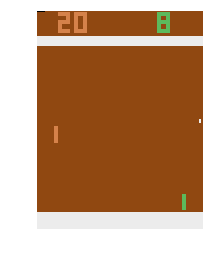

In [0]:
preprocess_observations = []

with tf.Session() as sess:
  saver.restore(sess, checkpoint_path)

  def dqn_policy(obs, i):
    if len(preprocess_observations) < 3:
      preprocess_observations.append(preprocess_observation(obs))
      if len(preprocess_observations) == 3:
        state = combine_observations(preprocess_observations)
        q_values = online_q_values.eval(
            feed_dict={X_state: [state.reshape(80, 80, 1)]})
        dqn_policy.cur_action = np.argmax(q_values)
      return dqn_policy.cur_action
    preprocess_observations[i % 3] = preprocess_observation(obs)
    if i % 3 == 2:
      state = combine_observations(preprocess_observations)
      q_values = online_q_values.eval(
          feed_dict={X_state: [state.reshape(80, 80, 1)]})
      dqn_policy.cur_action = np.argmax(q_values)
    return dqn_policy.cur_action
  dqn_policy.cur_action = 0

  html = run_episode(dqn_policy, n_max_steps=10000)
html